### Задача проекта - предасказание цен на недвижимость ###

__Подгружаем библиотеки__

In [1]:
import numpy as np
import pandas as pd
import random

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
%config InlineBackend.figure_format = 'svg' 

from pylab import rcParams
rcParams['figure.figsize'] = 8, 5

from sklearn.model_selection import train_test_split, cross_val_score

from sklearn.linear_model import RidgeCV
from sklearn.svm import LinearSVR

from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import StackingRegressor
# from sklearn.ensemble import VotingRegressor
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score as r2
from sklearn.model_selection import KFold, GridSearchCV

from sklearn.ensemble import GradientBoostingRegressor

from sklearn.preprocessing import StandardScaler

In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
def evaluate_preds(train_true_values, train_pred_values, test_true_values, test_pred_values):
    print("Train R2:\t" + str(round(r2(train_true_values, train_pred_values), 3)))
    print("Test R2:\t" + str(round(r2(test_true_values, test_pred_values), 3)))
    
    plt.figure(figsize=(12,6))
    
    plt.subplot(121)
    sns.scatterplot(x=train_pred_values, y=train_true_values)
    plt.xlabel('Predicted values')
    plt.ylabel('True values')
    plt.title('Train sample prediction')
    
    plt.subplot(122)
    sns.scatterplot(x=test_pred_values, y=test_true_values)
    plt.xlabel('Predicted values')
    plt.ylabel('True values')
    plt.title('Test sample prediction')

    plt.show()

__Настройка путей к файлам__

In [4]:
TRAIN_DATASET_PATH = './data/train.csv'
PREPARED_TRAIN_DATASET_PATH = './data/train_prepared.csv'
TEST_DATASET_PATH = './data/test.csv'

**Описание датасета**

* **Id** - идентификационный номер квартиры
* **DistrictId** - идентификационный номер района
* **Rooms** - количество комнат
* **Square** - площадь
* **LifeSquare** - жилая площадь
* **KitchenSquare** - площадь кухни
* **Floor** - этаж
* **HouseFloor** - количество этажей в доме
* **HouseYear** - год постройки дома
* **Ecology_1, Ecology_2, Ecology_3** - экологические показатели местности
* **Social_1, Social_2, Social_3** - социальные показатели местности
* **Healthcare_1, Helthcare_2** - показатели местности, связанные с охраной здоровья
* **Shops_1, Shops_2** - показатели, связанные с наличием магазинов, торговых центров
* **Price** - цена квартиры

In [5]:
train_df = pd.read_csv(TRAIN_DATASET_PATH)
train_df.tail()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price
9995,77,32,2.0,50.401785,30.476203,5.0,6,5.0,1968,0.135650,B,B,46,7960,6,350.0,3,11,B,196684.316040
9996,6159,18,1.0,41.521546,20.539216,9.0,13,13.0,2000,0.000000,B,B,30,5562,0,NaN,0,5,A,189050.289571
9997,5123,27,1.0,47.939008,NaN,1.0,12,16.0,2015,0.072158,B,B,2,629,1,NaN,0,0,A,159143.805370
9998,5400,75,2.0,43.602562,33.840147,8.0,1,5.0,1961,0.307467,B,A,30,5048,9,325.0,2,5,B,181595.339808
9999,6306,128,1.0,38.666645,21.157874,8.0,7,17.0,1990,0.000000,B,B,27,4798,0,30.0,2,8,B,218714.077615


In [6]:
test_df = pd.read_csv(TEST_DATASET_PATH)
test_df.tail()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2
4995,8180,11,3.0,67.133911,50.809797,6.0,5,9.0,1973,0.000170,B,B,36,5992,0,NaN,1,1,B
4996,4695,1,1.0,40.198472,21.807061,10.0,12,17.0,2017,0.007122,B,B,1,264,0,NaN,0,1,B
4997,5783,12,3.0,77.842178,48.282625,9.0,23,22.0,1989,0.090799,B,B,74,19083,2,NaN,5,15,B
4998,4780,62,2.0,81.305222,NaN,0.0,4,0.0,1977,0.072158,B,B,2,629,1,NaN,0,0,A
4999,12504,30,2.0,60.555693,NaN,1.0,10,17.0,1977,0.000078,B,B,22,6398,141,1046.0,3,23,B


In [7]:
train_df.shape, test_df.shape

((10000, 20), (5000, 19))

In [8]:
train_df.shape[1]-1 == test_df.shape[1]

True

### Целевая переменная ###

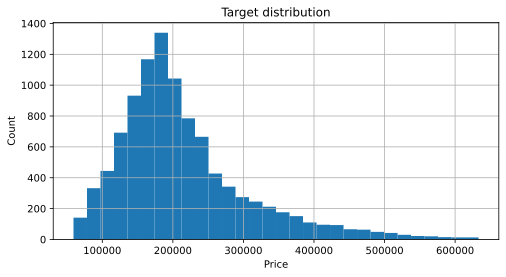

In [9]:
plt.figure(figsize = (8, 4))

train_df['Price'].hist(bins=30)
plt.ylabel('Count')
plt.xlabel('Price')

plt.title('Target distribution')
plt.show()

**Обработка значений параметров**

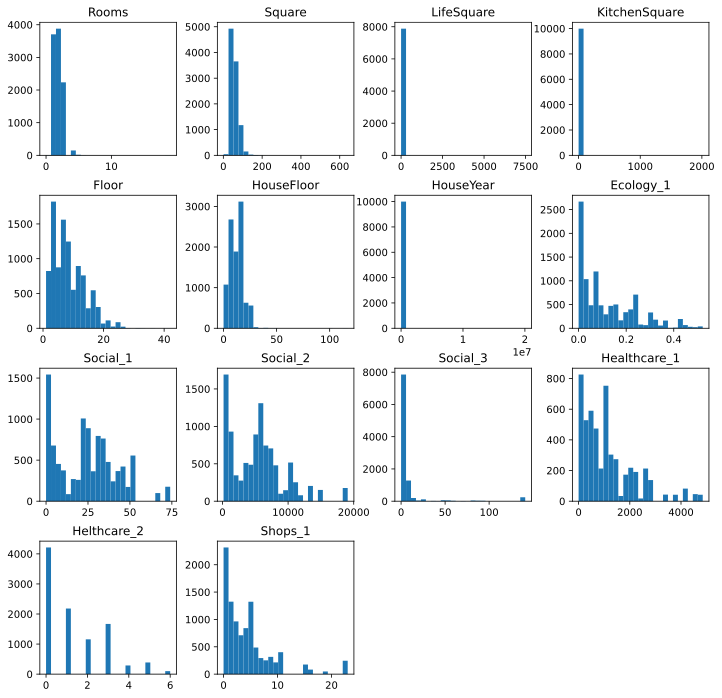

In [10]:
train_df.drop(['Id','DistrictId', 'Price'], axis=1, inplace=False).hist(figsize=(12,12), bins=25, grid=False)
plt.show()

In [11]:
train_df.columns

Index(['Id', 'DistrictId', 'Rooms', 'Square', 'LifeSquare', 'KitchenSquare',
       'Floor', 'HouseFloor', 'HouseYear', 'Ecology_1', 'Ecology_2',
       'Ecology_3', 'Social_1', 'Social_2', 'Social_3', 'Healthcare_1',
       'Helthcare_2', 'Shops_1', 'Shops_2', 'Price'],
      dtype='object')

In [12]:
train_df.describe()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Price
count,10000.00000,10000.000000,10000.000000,10000.000000,7887.000000,10000.000000,10000.000000,10000.000000,1.000000e+04,10000.000000,10000.000000,10000.000000,10000.000000,5202.000000,10000.000000,10000.000000,10000.000000
mean,8383.40770,50.400800,1.890500,56.315775,37.199645,6.273300,8.526700,12.609400,3.990166e+03,0.118858,24.687000,5352.157400,8.039200,1142.904460,1.319500,4.231300,214138.857399
std,4859.01902,43.587592,0.839512,21.058732,86.241209,28.560917,5.241148,6.775974,2.005003e+05,0.119025,17.532614,4006.799803,23.831875,1021.517264,1.493601,4.806341,92872.293865
min,0.00000,0.000000,0.000000,1.136859,0.370619,0.000000,1.000000,0.000000,1.910000e+03,0.000000,0.000000,168.000000,0.000000,0.000000,0.000000,0.000000,59174.778028
25%,4169.50000,20.000000,1.000000,41.774881,22.769832,1.000000,4.000000,9.000000,1.974000e+03,0.017647,6.000000,1564.000000,0.000000,350.000000,0.000000,1.000000,153872.633942
50%,8394.50000,36.000000,2.000000,52.513310,32.781260,6.000000,7.000000,13.000000,1.977000e+03,0.075424,25.000000,5285.000000,2.000000,900.000000,1.000000,3.000000,192269.644879
75%,12592.50000,75.000000,2.000000,65.900625,45.128803,9.000000,12.000000,17.000000,2.001000e+03,0.195781,36.000000,7227.000000,5.000000,1548.000000,2.000000,6.000000,249135.462171
max,16798.00000,209.000000,19.000000,641.065193,7480.592129,2014.000000,42.000000,117.000000,2.005201e+07,0.521867,74.000000,19083.000000,141.000000,4849.000000,6.000000,23.000000,633233.466570


In [13]:
train_df.dtypes

Id                 int64
DistrictId         int64
Rooms            float64
Square           float64
LifeSquare       float64
KitchenSquare    float64
Floor              int64
HouseFloor       float64
HouseYear          int64
Ecology_1        float64
Ecology_2         object
Ecology_3         object
Social_1           int64
Social_2           int64
Social_3           int64
Healthcare_1     float64
Helthcare_2        int64
Shops_1            int64
Shops_2           object
Price            float64
dtype: object

### Обработка выбросов и пропусков ###

#### Rooms

In [14]:
train_df['Rooms'].value_counts()

2.0     3880
1.0     3705
3.0     2235
4.0      150
5.0       18
0.0        8
10.0       2
6.0        1
19.0       1
Name: Rooms, dtype: int64

In [15]:
train_df['Rooms_outlier'] = 0
train_df.loc[(train_df['Rooms'] == 0) | (train_df['Rooms'] > 6), 'Rooms_outlier'] = 1

train_df.loc[train_df['Rooms'] == 0, 'Rooms'] = 1
train_df.loc[train_df['Rooms'] > 6, 'Rooms'] = train_df['Rooms'].median()
train_df['Rooms'].value_counts()

2.0    3883
1.0    3713
3.0    2235
4.0     150
5.0      18
6.0       1
Name: Rooms, dtype: int64

#### Square

In [16]:
train_df['Square'].describe()

count    10000.000000
mean        56.315775
std         21.058732
min          1.136859
25%         41.774881
50%         52.513310
75%         65.900625
max        641.065193
Name: Square, dtype: float64

#### MedSquareByRooms

In [17]:
med_square_by_rooms_district = train_df.groupby(['Rooms','DistrictId'], as_index=False).agg({'Square':'median'}).\
                                            rename(columns={'Square':'MedSquareByRoomsDistrictId'})
med_square_by_rooms = train_df.groupby('Rooms', as_index=False).agg({'Square':'median'}).\
                                            rename(columns={'Square':'MedSquareByRooms'})

med_square_by_rooms.head(), med_square_by_rooms_district.head()

(   Rooms  MedSquareByRooms
 0    1.0         40.412437
 1    2.0         55.849288
 2    3.0         77.413643
 3    4.0         98.668054
 4    5.0        116.084861,
    Rooms  DistrictId  MedSquareByRoomsDistrictId
 0    1.0           0                   36.158717
 1    1.0           1                   42.498602
 2    1.0           2                   36.977507
 3    1.0           3                   36.418685
 4    1.0           4                   33.625103)

In [18]:
train_df = train_df.merge(med_square_by_rooms_district, on=['Rooms', 'DistrictId'], how='left')
train_df = train_df.merge(med_square_by_rooms, on='Rooms', how='left')
condition = train_df['MedSquareByRoomsDistrictId'].isna()
train_df.loc[condition, 'MedSquareByRoomsDistrictId'] = train_df.loc[condition, 'MedSquareByRooms']

In [19]:
train_df['Square_outlier'] = 0
condition = train_df['Square'] < np.quantile(train_df['Square'], q=0.025)
train_df.loc[condition, 'Square_outlier'] = 1
train_df.loc[condition, 'Square'] = train_df.loc[condition, 'MedSquareByRoomsDistrictId']

condition = train_df['Square'] > np.quantile(train_df['Square'], q=0.975)
train_df.loc[condition, 'Square_outlier'] = 1
train_df.loc[condition, 'Square'] = train_df.loc[condition, 'MedSquareByRoomsDistrictId']

train_df['Square'].describe(), train_df['Square'].isna().sum()

(count    10000.000000
 mean        55.764015
 std         17.151497
 min         25.778868
 25%         41.847683
 50%         52.415850
 75%         65.801812
 max        226.291341
 Name: Square, dtype: float64,
 0)

#### KitchenSquare

In [20]:
train_df['KitchenSquare'].describe()

count    10000.000000
mean         6.273300
std         28.560917
min          0.000000
25%          1.000000
50%          6.000000
75%          9.000000
max       2014.000000
Name: KitchenSquare, dtype: float64

In [21]:
train_df['KitchenSquare_outlier'] = 0

condition = train_df['KitchenSquare'] < 1
train_df.loc[condition, 'KitchenSquare'] = 1
train_df.loc[condition, 'KitchenSquare_outlier'] = 1

condition = train_df['KitchenSquare'] > np.quantile(train_df['KitchenSquare'], q=0.975)
train_df.loc[condition, 'KitchenSquare'] = np.quantile(train_df['KitchenSquare'], q=0.975)
train_df.loc[condition, 'KitchenSquare_outlier'] = 1

train_df['KitchenSquare'].describe()

count    10000.000000
mean         5.738700
std          3.712088
min          1.000000
25%          1.000000
50%          6.000000
75%          9.000000
max         13.000000
Name: KitchenSquare, dtype: float64

In [22]:
(train_df['Square'] < train_df['KitchenSquare']).sum()

0

#### LifeSquare

In [23]:
train_df['LifeSquare'].describe()

count    7887.000000
mean       37.199645
std        86.241209
min         0.370619
25%        22.769832
50%        32.781260
75%        45.128803
max      7480.592129
Name: LifeSquare, dtype: float64

In [24]:
train_df['LifeSquare'].isna().sum()

2113

In [25]:
train_df['LifeSquare_NaN'] = 0
train_df['LifeSquare_outlier'] = 0 

condition = train_df['LifeSquare'].isnull()
train_df.loc[condition, 'LifeSquare_NaN'] = 1
train_df.loc[condition, 'LifeSquare'] = train_df.loc[condition, 'Square'] -\
                                        train_df.loc[condition, 'KitchenSquare'] - 3

condition = train_df['LifeSquare'] < np.quantile(train_df['LifeSquare'], q=0.025)
train_df.loc[condition, 'LifeSquare_outlier'] = 1
train_df.loc[condition, 'LifeSquare'] = np.quantile(train_df['LifeSquare'], q=0.025)
train_df['LifeSquare'].isna().sum(), (train_df['LifeSquare'] < 0).sum()

(0, 0)

#### HouseYear

In [26]:
train_df['HouseYear'].sort_values(ascending=False)

1497    20052011
4189        4968
5701        2020
2493        2020
1499        2020
          ...   
7611        1916
910         1914
2656        1912
5111        1912
9317        1910
Name: HouseYear, Length: 10000, dtype: int64

In [27]:
train_df.loc[train_df['HouseYear'] > 2020, 'HouseYear'] = 2020

train_df['HouseYear_cat'] = pd.cut(train_df['HouseYear'], bins=10, labels=False)
train_df.head()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,...,Shops_2,Price,Rooms_outlier,MedSquareByRoomsDistrictId,MedSquareByRooms,Square_outlier,KitchenSquare_outlier,LifeSquare_NaN,LifeSquare_outlier,HouseYear_cat
0,14038,35,2.0,47.981561,29.442751,6.0,7,9.0,1969,0.089040,...,B,184966.930730,0,48.115670,55.849288,0,0,0,0,5
1,15053,41,3.0,65.683640,40.049543,8.0,7,9.0,1978,0.000070,...,B,300009.450063,0,70.733227,77.413643,0,0,0,0,6
2,4765,53,2.0,44.947953,29.197612,1.0,8,12.0,1968,0.049637,...,B,220925.908524,0,56.803895,55.849288,0,1,0,0,5
3,5809,58,2.0,53.352981,52.731512,9.0,8,17.0,1977,0.437885,...,B,175616.227217,0,61.374363,55.849288,0,0,0,0,6
4,10783,99,1.0,39.649192,23.776169,7.0,11,12.0,1976,0.012339,...,B,150226.531644,0,37.186749,40.412437,0,0,0,0,5


#### HouseFloor

In [28]:
train_df['HouseFloor'].describe()

count    10000.000000
mean        12.609400
std          6.775974
min          0.000000
25%          9.000000
50%         13.000000
75%         17.000000
max        117.000000
Name: HouseFloor, dtype: float64

In [29]:
(train_df['HouseFloor'] == 0).sum()

269

In [30]:
med_housefloor_by_district = train_df.groupby('DistrictId', as_index=False).agg({'Floor':'median'}).\
                                            rename(columns={'Floor':'MedHouseFloorByDistrict'})
train_df = train_df.merge(med_housefloor_by_district, on='DistrictId', how='left')

train_df.head()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,...,Price,Rooms_outlier,MedSquareByRoomsDistrictId,MedSquareByRooms,Square_outlier,KitchenSquare_outlier,LifeSquare_NaN,LifeSquare_outlier,HouseYear_cat,MedHouseFloorByDistrict
0,14038,35,2.0,47.981561,29.442751,6.0,7,9.0,1969,0.089040,...,184966.930730,0,48.115670,55.849288,0,0,0,0,5,7.0
1,15053,41,3.0,65.683640,40.049543,8.0,7,9.0,1978,0.000070,...,300009.450063,0,70.733227,77.413643,0,0,0,0,6,8.0
2,4765,53,2.0,44.947953,29.197612,1.0,8,12.0,1968,0.049637,...,220925.908524,0,56.803895,55.849288,0,1,0,0,5,8.0
3,5809,58,2.0,53.352981,52.731512,9.0,8,17.0,1977,0.437885,...,175616.227217,0,61.374363,55.849288,0,0,0,0,6,7.0
4,10783,99,1.0,39.649192,23.776169,7.0,11,12.0,1976,0.012339,...,150226.531644,0,37.186749,40.412437,0,0,0,0,5,7.0


In [31]:
train_df['HouseFloor_outlier'] = 0
condition = train_df['HouseFloor'] == 0
train_df.loc[condition, 'HouseFloor_outlier'] = 1
train_df.loc[condition, 'HouseFloor'] = train_df.loc[condition, 'MedHouseFloorByDistrict']

#### Floor

In [32]:
train_df['Floor'].describe()

count    10000.000000
mean         8.526700
std          5.241148
min          1.000000
25%          4.000000
50%          7.000000
75%         12.000000
max         42.000000
Name: Floor, dtype: float64

In [33]:
(train_df['HouseFloor'] < train_df['Floor']).sum()

1679

In [34]:
condition = train_df['HouseFloor'] < train_df['Floor']
train_df.loc[condition, 'HouseFloor_outlier'] = 1

train_df.loc[condition, 'Floor'] = train_df.loc[condition, 'HouseFloor'].apply(lambda x: random.randint(1, int(x)))
(train_df['HouseFloor'] < train_df['Floor']).sum()

0

#### Healthcare_1

In [35]:
train_df['Healthcare_1'].describe()

count    5202.000000
mean     1142.904460
std      1021.517264
min         0.000000
25%       350.000000
50%       900.000000
75%      1548.000000
max      4849.000000
Name: Healthcare_1, dtype: float64

In [36]:
train_df['Healthcare_1'].isna().sum()

4798

In [37]:
train_df.loc[train_df['Healthcare_1'].isna(), 'Healthcare_1'] = 9999

In [38]:
train_df.describe()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,...,Rooms_outlier,MedSquareByRoomsDistrictId,MedSquareByRooms,Square_outlier,KitchenSquare_outlier,LifeSquare_NaN,LifeSquare_outlier,HouseYear_cat,MedHouseFloorByDistrict,HouseFloor_outlier
count,10000.00000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,...,10000.00000,10000.000000,10000.000000,10000.000000,10000.00000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000
mean,8383.40770,50.400800,1.888000,55.764015,41.145194,5.738700,7.369400,12.836300,1984.872400,0.118858,...,0.00110,55.531000,55.688280,0.050000,0.08860,0.211300,0.025000,6.356000,7.713200,0.182500
std,4859.01902,43.587592,0.812479,17.151497,77.222366,3.712088,5.046136,6.490922,18.416347,0.119025,...,0.03315,16.757157,15.048003,0.217956,0.28418,0.408251,0.156133,1.636866,1.994842,0.386275
min,0.00000,0.000000,1.000000,25.778868,15.146124,1.000000,1.000000,1.000000,1910.000000,0.000000,...,0.00000,25.778868,40.412437,0.000000,0.00000,0.000000,0.000000,0.000000,2.000000,0.000000
25%,4169.50000,20.000000,1.000000,41.847683,25.478190,1.000000,3.000000,9.000000,1974.000000,0.017647,...,0.00000,41.972654,40.412437,0.000000,0.00000,0.000000,0.000000,5.000000,6.000000,0.000000
50%,8394.50000,36.000000,2.000000,52.415850,36.300245,6.000000,6.000000,13.000000,1977.000000,0.075424,...,0.00000,49.871159,55.849288,0.000000,0.00000,0.000000,0.000000,6.000000,8.000000,0.000000
75%,12592.50000,75.000000,2.000000,65.801812,48.978842,9.000000,10.000000,17.000000,2001.000000,0.195781,...,0.00000,64.144778,55.849288,0.000000,0.00000,0.000000,0.000000,8.000000,9.000000,0.000000
max,16798.00000,209.000000,6.000000,226.291341,7480.592129,13.000000,42.000000,117.000000,2020.000000,0.521867,...,1.00000,226.291341,116.084861,1.000000,1.00000,1.000000,1.000000,9.000000,14.500000,1.000000


In [39]:
train_df.head()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,...,Rooms_outlier,MedSquareByRoomsDistrictId,MedSquareByRooms,Square_outlier,KitchenSquare_outlier,LifeSquare_NaN,LifeSquare_outlier,HouseYear_cat,MedHouseFloorByDistrict,HouseFloor_outlier
0,14038,35,2.0,47.981561,29.442751,6.0,7,9.0,1969,0.089040,...,0,48.115670,55.849288,0,0,0,0,5,7.0,0
1,15053,41,3.0,65.683640,40.049543,8.0,7,9.0,1978,0.000070,...,0,70.733227,77.413643,0,0,0,0,6,8.0,0
2,4765,53,2.0,44.947953,29.197612,1.0,8,12.0,1968,0.049637,...,0,56.803895,55.849288,0,1,0,0,5,8.0,0
3,5809,58,2.0,53.352981,52.731512,9.0,8,17.0,1977,0.437885,...,0,61.374363,55.849288,0,0,0,0,6,7.0,0
4,10783,99,1.0,39.649192,23.776169,7.0,11,12.0,1976,0.012339,...,0,37.186749,40.412437,0,0,0,0,5,7.0,0


Для всех внесённых изменений создадим класс

In [40]:
class DataPreprocessing:
    """Подготовка исходных данных"""

    def __init__(self):
        """Параметры класса"""
        self.medians = None
        self.kitchen_square_quantile = None
        self.square_quantile_025 = None
        self.square_quantile_975 = None
        self.lifesquare_quantile_025 = None
        self.lifesquare_quantile_975 = None
        self.med_square_by_rooms = None
        self.med_square_by_rooms_district = None
        self.men_lifesquare_square_cat = None


    def fit(self, X):
        """Сохранение статистик"""       
        # Расчет медиан
        self.medians = X.median()
        self.square_quantile_975 = X['Square'].quantile(.975)
        self.square_quantile_025 = X['Square'].quantile(.025)
        self.lifesquare_quantile_025 = X['LifeSquare'].quantile(.025)
        self.lifesquare_quantile_975 = X['LifeSquare'].quantile(.975)
        self.kitchen_square_quantile = X['KitchenSquare'].quantile(.975)

        self.med_square_by_rooms_district = X.groupby(['Rooms','DistrictId'], as_index=False).agg({'Square':'median'}).\
                                            rename(columns={'Square':'MedSquareByRoomsDistrictId'})
        self.med_square_by_rooms = X.groupby('Rooms', as_index=False).agg({'Square':'median'}).\
                                                    rename(columns={'Square':'MedSquareByRooms'})


    
    def transform(self, X):
        """Трансформация данных"""

        # Rooms
        X['Rooms_outlier'] = 0
        X.loc[(X['Rooms'] == 0) | (X['Rooms'] >= 6), 'Rooms_outlier'] = 1

        X.loc[X['Rooms'] == 0, 'Rooms'] = 1
        X.loc[X['Rooms'] > 6, 'Rooms'] = self.medians['Rooms']
        
        #Square
        X = X.merge(self.med_square_by_rooms_district, on=['Rooms', 'DistrictId'], how='left')
        X = X.merge(self.med_square_by_rooms, on='Rooms', how='left')
        
        condition = X['MedSquareByRoomsDistrictId'].isna()
        X.loc[condition, 'MedSquareByRoomsDistrictId'] = X.loc[condition, 'MedSquareByRooms']

        X['Square_outlier'] = 0
        condition = X['Square'] < self.square_quantile_025
        X.loc[condition, 'Square_outlier'] = 1
        X.loc[condition, 'Square'] = X.loc[condition, 'MedSquareByRoomsDistrictId']

        condition = X['Square'] > self.square_quantile_975
        X.loc[condition, 'Square_outlier'] = 1
        X.loc[condition, 'Square'] = X.loc[condition, 'MedSquareByRoomsDistrictId']


        #KitchenSquare
        X['KitchenSquare_outlier'] = 0

        condition = X['KitchenSquare'] < 1
        X.loc[condition, 'KitchenSquare'] = 1
        X.loc[condition, 'KitchenSquare_outlier'] = 1

        condition = X['KitchenSquare'] > self.kitchen_square_quantile
        X.loc[condition, 'KitchenSquare'] = self.kitchen_square_quantile
        X.loc[condition, 'KitchenSquare_outlier'] = 1



        #LifeSquare
        X['LifeSquare_NaN'] = 0
        X['LifeSquare_outlier'] = 0 

        condition = X['LifeSquare'].isnull()
        X.loc[condition, 'LifeSquare_NaN'] = 1
        X.loc[condition, 'LifeSquare'] = X.loc[condition, 'Square'] -\
                                                X.loc[condition, 'KitchenSquare'] - 3

        condition = X['LifeSquare'] < self.lifesquare_quantile_025
        X.loc[condition, 'LifeSquare_outlier'] = 1
        X.loc[condition, 'LifeSquare'] = self.lifesquare_quantile_975
        X['LifeSquare'].isna().sum(), (X['LifeSquare'] < 0).sum()

        #HouseYear
        X.loc[X['HouseYear'] > 2020, 'HouseYear'] = 2020


        #HouseFloor
        med_housefloor_by_district = X.groupby('DistrictId', as_index=False).\
                                    agg({'Floor':'median'}).rename(columns={'Floor':'MedHouseFloorByDistrict'})
        X = X.merge(med_housefloor_by_district, on='DistrictId', how='left')

        condition = X['HouseFloor'] == 0
        X.loc[condition, 'HouseFloor'] = X.loc[condition, 'MedHouseFloorByDistrict']

        condition = X['HouseFloor'] < X['Floor']
        X.loc[condition, 'Floor'] = X.loc[condition, 'HouseFloor'].apply(lambda x: random.randint(1, int(x)))

        #Healthcare_1
#         X.drop('Healthcare_1', axis=1, inplace=True)
        X.loc[X['Healthcare_1'].isna(), 'Healthcare_1'] = -1

        return X

#### Построение новых признаков ####

In [41]:
# binary_to_numbers = {'A': 0, 'B': 1}

# train_df['Ecology_2'] = train_df['Ecology_2'].replace(binary_to_numbers)
# train_df['Ecology_3'] = train_df['Ecology_3'].replace(binary_to_numbers)
# train_df['Shops_2'] = train_df['Shops_2'].replace(binary_to_numbers)

dummy_col_name = ['Ecology_2', 'Ecology_3', 'Shops_2']

train_df = pd.concat([train_df, pd.get_dummies(train_df[dummy_col_name], prefix=dummy_col_name)], axis=1)
train_df.head()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,...,LifeSquare_outlier,HouseYear_cat,MedHouseFloorByDistrict,HouseFloor_outlier,Ecology_2_A,Ecology_2_B,Ecology_3_A,Ecology_3_B,Shops_2_A,Shops_2_B
0,14038,35,2.0,47.981561,29.442751,6.0,7,9.0,1969,0.089040,...,0,5,7.0,0,0,1,0,1,0,1
1,15053,41,3.0,65.683640,40.049543,8.0,7,9.0,1978,0.000070,...,0,6,8.0,0,0,1,0,1,0,1
2,4765,53,2.0,44.947953,29.197612,1.0,8,12.0,1968,0.049637,...,0,5,8.0,0,0,1,0,1,0,1
3,5809,58,2.0,53.352981,52.731512,9.0,8,17.0,1977,0.437885,...,0,6,7.0,0,0,1,0,1,0,1
4,10783,99,1.0,39.649192,23.776169,7.0,11,12.0,1976,0.012339,...,0,5,7.0,0,0,1,0,1,0,1


In [42]:
train_df

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,...,LifeSquare_outlier,HouseYear_cat,MedHouseFloorByDistrict,HouseFloor_outlier,Ecology_2_A,Ecology_2_B,Ecology_3_A,Ecology_3_B,Shops_2_A,Shops_2_B
0,14038,35,2.0,47.981561,29.442751,6.0,7,9.0,1969,0.089040,...,0,5,7.0,0,0,1,0,1,0,1
1,15053,41,3.0,65.683640,40.049543,8.0,7,9.0,1978,0.000070,...,0,6,8.0,0,0,1,0,1,0,1
2,4765,53,2.0,44.947953,29.197612,1.0,8,12.0,1968,0.049637,...,0,5,8.0,0,0,1,0,1,0,1
3,5809,58,2.0,53.352981,52.731512,9.0,8,17.0,1977,0.437885,...,0,6,7.0,0,0,1,0,1,0,1
4,10783,99,1.0,39.649192,23.776169,7.0,11,12.0,1976,0.012339,...,0,5,7.0,0,0,1,0,1,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,77,32,2.0,50.401785,30.476203,5.0,4,5.0,1968,0.135650,...,0,5,6.0,1,0,1,0,1,0,1
9996,6159,18,1.0,41.521546,20.539216,9.0,13,13.0,2000,0.000000,...,0,8,10.0,0,0,1,0,1,1,0
9997,5123,27,1.0,47.939008,43.939008,1.0,12,16.0,2015,0.072158,...,0,9,8.0,0,0,1,0,1,1,0
9998,5400,75,2.0,43.602562,33.840147,8.0,1,5.0,1961,0.307467,...,0,4,5.0,0,0,1,1,0,0,1


In [43]:
# первый/последний этаж
train_df['FirstLastFloor'] = 0
train_df.loc[(train_df['Floor'] == 1) | (train_df['Floor'] == train_df['HouseFloor']), 'FirstLastFloor'] = 1
(train_df['FirstLastFloor'] == 1).sum()

1992

In [44]:
# средняя стоимость метра в районе
med_price_by_district = train_df.groupby(['DistrictId', 'Rooms'], as_index=False).agg({'Price':'median'})\
                            .rename(columns={'Price':'MedPriceByDistrict'})

med_price_by_district.head()

,DistrictId,Rooms,MedPriceByDistrict
0,0,1.0,142799.434052
1,0,2.0,176210.812334
2,0,3.0,300610.359425
3,1,1.0,146735.671740
4,1,2.0,202666.310126


In [45]:
train_df = train_df.merge(med_price_by_district, on=['DistrictId', 'Rooms'], how='left')
train_df.head()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,...,MedHouseFloorByDistrict,HouseFloor_outlier,Ecology_2_A,Ecology_2_B,Ecology_3_A,Ecology_3_B,Shops_2_A,Shops_2_B,FirstLastFloor,MedPriceByDistrict
0,14038,35,2.0,47.981561,29.442751,6.0,7,9.0,1969,0.089040,...,7.0,0,0,1,0,1,0,1,0,207786.135836
1,15053,41,3.0,65.683640,40.049543,8.0,7,9.0,1978,0.000070,...,8.0,0,0,1,0,1,0,1,0,300009.450063
2,4765,53,2.0,44.947953,29.197612,1.0,8,12.0,1968,0.049637,...,8.0,0,0,1,0,1,0,1,0,263206.223152
3,5809,58,2.0,53.352981,52.731512,9.0,8,17.0,1977,0.437885,...,7.0,0,0,1,0,1,0,1,0,166809.665642
4,10783,99,1.0,39.649192,23.776169,7.0,11,12.0,1976,0.012339,...,7.0,0,0,1,0,1,0,1,0,158539.052715


In [46]:
# # приведение Ecology_ к одному параметру
# train_df['EcologySum'] = train_df['Ecology_1'] + train_df['Ecology_2'] + train_df['Ecology_3']
# train_df.head()

In [47]:
def floor_to_cat(data):
    bins = [0, 3, 5, 9, 15, data['Floor'].max()]
    data['floor_cat'] = pd.cut(data['Floor'], bins=bins, labels=False)

    data['floor_cat'].fillna(-1, inplace=True) 
    return data

def year_to_cat(data):
    bins = [0, 1941, 1945, 1980, 2000, 2010, data['HouseYear'].max()]
    data['year_cat'] = pd.cut(data['HouseYear'], bins=bins, labels=False)

    data['year_cat'].fillna(-1, inplace=True)
    return data

In [48]:
train_df = year_to_cat(train_df)
train_df = floor_to_cat(train_df)
train_df.head()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,...,Ecology_2_A,Ecology_2_B,Ecology_3_A,Ecology_3_B,Shops_2_A,Shops_2_B,FirstLastFloor,MedPriceByDistrict,year_cat,floor_cat
0,14038,35,2.0,47.981561,29.442751,6.0,7,9.0,1969,0.089040,...,0,1,0,1,0,1,0,207786.135836,2,2
1,15053,41,3.0,65.683640,40.049543,8.0,7,9.0,1978,0.000070,...,0,1,0,1,0,1,0,300009.450063,2,2
2,4765,53,2.0,44.947953,29.197612,1.0,8,12.0,1968,0.049637,...,0,1,0,1,0,1,0,263206.223152,2,2
3,5809,58,2.0,53.352981,52.731512,9.0,8,17.0,1977,0.437885,...,0,1,0,1,0,1,0,166809.665642,2,2
4,10783,99,1.0,39.649192,23.776169,7.0,11,12.0,1976,0.012339,...,0,1,0,1,0,1,0,158539.052715,2,3


In [49]:
class FeatureGenetator():
    """Генерация новых фич"""

    def __init__(self):
        self.binary_to_numbers = None
        self.med_price_by_district = None
        self.med_price_by_district_median = None
        self.house_year_max = None
        self.floor_max = None


    def fit(self, X, y=None):

        X = X.copy()

        # Binary features
        self.binary_to_numbers = {'A': 0, 'B': 1}
        
        df = X.copy()
        
        if y is not None:
            df['Price'] = y.values
            
            self.med_price_by_district = df.groupby(['DistrictId', 'Rooms'], as_index=False).agg({'Price':'median'})\
                                            .rename(columns={'Price':'MedPriceByDistrict'})
            
            self.med_price_by_district_median = self.med_price_by_district['MedPriceByDistrict'].median()
            
        ## floor, year
        if y is not None:
            self.floor_max = df['Floor'].max()
            self.house_year_max = df['HouseYear'].max()
            df['Price'] = y.values
            df = self.floor_to_cat(df)
            df = self.year_to_cat(df)
            self.med_price_by_floor_year = df.groupby(['year_cat', 'floor_cat'], as_index=False).agg({'Price':'median'}).\
                                            rename(columns={'Price':'MedPriceByFloorYear'})
            self.med_price_by_floor_year_median = self.med_price_by_floor_year['MedPriceByFloorYear'].median()


    def transform(self, X):
        
#         # Binary features
#         X['Ecology_2'] = X['Ecology_2'].map(self.binary_to_numbers)  # self.binary_to_numbers = {'A': 0, 'B': 1}
#         X['Ecology_3'] = X['Ecology_3'].map(self.binary_to_numbers)
#         X['Shops_2'] = X['Shops_2'].map(self.binary_to_numbers)

        dummy_col_name = ['Ecology_2', 'Ecology_3', 'Shops_2']

        X = pd.concat([X, pd.get_dummies(X[dummy_col_name], prefix=dummy_col_name)], axis=1)


        #HouseFloor_outlier
        X['HouseFloor_outlier'] = 0
        X.loc[X['HouseFloor'] < X['Floor'], 'HouseFloor_outlier'] = 1
        X.loc[X['HouseFloor'] == 0, 'HouseFloor_outlier'] = 1


        # первый/последний этаж
        X['FirstLastFloor'] = 0
        X.loc[(X['Floor'] == 1) | (X['Floor'] == X['HouseFloor']), 'FirstLastFloor'] = 1

        # средняя стоимость метра в районе
        if self.med_price_by_district is not None:
            X = X.merge(self.med_price_by_district, on=['DistrictId', 'Rooms'], how='left')
            X['MedPriceByDistrict'].fillna(self.med_price_by_district_median, inplace=True)
            
        # приведение Ecology_ к одному параметру
#         X['EcologySum'] = X['Ecology_1'] + X['Ecology_2'] + X['Ecology_3']
        
        # HouseYear cat
        X['HouseYear_cat'] = pd.cut(X['HouseYear'], bins=4, labels=False)
        
        # More categorical features
        X = self.floor_to_cat(X)  # + столбец floor_cat
        X = self.year_to_cat(X)   # + столбец year_cat
        
        # Mid Price by Floor/Year
        if self.med_price_by_floor_year is not None:
            X = X.merge(self.med_price_by_floor_year, on=['year_cat', 'floor_cat'], how='left')
            X['MedPriceByFloorYear'].fillna(self.med_price_by_floor_year_median, inplace=True)
            
        #Healthcare_1_NaN
        
        X['Healthcare_1_NaN'] = 0
        X.loc[X['Healthcare_1'] == -1, 'Healthcare_1_NaN'] = 1


        return X
    
    
    def floor_to_cat(self, X):
        bins = [0, 3, 5, 9, 15, self.floor_max]
        X['floor_cat'] = pd.cut(X['Floor'], bins=bins, labels=False)

        X['floor_cat'].fillna(-1, inplace=True) 
        return X
     
    def year_to_cat(self, X):
        bins = [0, 1941, 1945, 1980, 2000, 2010, self.house_year_max]
        X['year_cat'] = pd.cut(X['HouseYear'], bins=bins, labels=False)

        X['year_cat'].fillna(-1, inplace=True)
        return X



#### Отбор признаков ####

In [50]:
train_df.columns.to_list()

['Id',
 'DistrictId',
 'Rooms',
 'Square',
 'LifeSquare',
 'KitchenSquare',
 'Floor',
 'HouseFloor',
 'HouseYear',
 'Ecology_1',
 'Ecology_2',
 'Ecology_3',
 'Social_1',
 'Social_2',
 'Social_3',
 'Healthcare_1',
 'Helthcare_2',
 'Shops_1',
 'Shops_2',
 'Price',
 'Rooms_outlier',
 'MedSquareByRoomsDistrictId',
 'MedSquareByRooms',
 'Square_outlier',
 'KitchenSquare_outlier',
 'LifeSquare_NaN',
 'LifeSquare_outlier',
 'HouseYear_cat',
 'MedHouseFloorByDistrict',
 'HouseFloor_outlier',
 'Ecology_2_A',
 'Ecology_2_B',
 'Ecology_3_A',
 'Ecology_3_B',
 'Shops_2_A',
 'Shops_2_B',
 'FirstLastFloor',
 'MedPriceByDistrict',
 'year_cat',
 'floor_cat']

In [70]:
feature_names = [
'Rooms',
 'Square',
 'LifeSquare',
 'KitchenSquare',
#  'Floor',
 'HouseFloor',
#  'HouseYear',
 'Ecology_1',
#  'Ecology_2',
#  'Ecology_3',
 'Social_1',
 'Social_2',
 'Social_3',
 'Helthcare_2',
'Healthcare_1', 
 'Shops_1',
#  'Shops_2',
]

new_feature_names = [
'Rooms_outlier',
 'MedSquareByRoomsDistrictId',
 'MedSquareByRooms',
 'Square_outlier',
 'KitchenSquare_outlier',
 'LifeSquare_NaN',
 'LifeSquare_outlier',
#  'HouseYear_cat',
 'MedHouseFloorByDistrict',
 'HouseFloor_outlier',
 'FirstLastFloor',
#  'MedPriceByDistrict',
#  'EcologySum',
 'year_cat',
 'floor_cat',
#  'Ecology_2_A',
 'Ecology_2_B',
#  'Ecology_3_A',
 'Ecology_3_B',
#  'Shops_2_A',
 'Shops_2_B',
 'Healthcare_1_NaN'
]

target_name = 'Price'

#### Разбиение данных на train и test ####

In [71]:
train_df = pd.read_csv(TRAIN_DATASET_PATH)
test_df = pd.read_csv(TEST_DATASET_PATH)

X = train_df.drop(columns=target_name)
y = train_df[target_name]

X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.33, shuffle=True, random_state=21)

In [72]:
preprocessor = DataPreprocessing()
preprocessor.fit(X_train)

X_train = preprocessor.transform(X_train)
X_valid = preprocessor.transform(X_valid)
test_df = preprocessor.transform(test_df)

X_train.shape, X_valid.shape, test_df.shape

((6700, 27), (3300, 27), (5000, 27))

In [73]:
features_gen = FeatureGenetator()
features_gen.fit(X_train, y_train)

X_train = features_gen.transform(X_train)
X_valid = features_gen.transform(X_valid)
test_df = features_gen.transform(test_df)

X_train.shape, X_valid.shape, test_df.shape

((6700, 41), (3300, 41), (5000, 41))

In [74]:
X_train = X_train[feature_names + new_feature_names]
X_valid = X_valid[feature_names + new_feature_names]
test_df = test_df[feature_names + new_feature_names]

In [75]:
X_train.isna().sum().sum(), X_valid.isna().sum().sum(), test_df.isna().sum().sum()

(0, 0, 0)

### Построение модели ###

Обучение

In [76]:
# %%time

# rfc=RandomForestRegressor(random_state=21)
# tuned_parameters = {
#     'n_estimators': [50, 100, 200, 300, 500, 700, 1000], 'max_depth': [3, 5, 7, 10]
# }

# clf = GridSearchCV(rfc, tuned_parameters, scoring='r2', cv=KFold(n_splits=5, random_state=21, shuffle=True),
#                   n_jobs=-1)

# clf.fit(X_train, y_train)

In [77]:
# %%capture stored_output

# clf.best_params_

In [78]:
# stored_output()
# # {'max_depth': None, 'min_samples_split': 3, 'n_estimators': 500}
# # GradientForestRegressor. {'max_depth': 3, 'n_estimators': 300}

In [79]:
# rf_model = RandomForestRegressor(random_state=21, criterion='mse')

# Train R2:	0.96
# Test R2:	0.71

# rf_model = RandomForestRegressor(random_state=21, criterion='mse', max_depth=None, \
#                                  min_samples_split=3, n_estimators=300)
# Train R2:	0.957
# Test R2:	0.708

# rf_model = RandomForestRegressor(random_state=21, criterion='mse', max_depth=None, \
#                                  n_estimators=1000, min_samples_split=3)

# Train R2:	0.958
# Test R2:	0.706

# estimators = [
#         ('lr', RidgeCV()),
#         ('svr', LinearSVR(random_state=21))
# ]

# rf_model = StackingRegressor(estimators=estimators, final_estimator=\
#                              RandomForestRegressor(random_state=21, criterion='mse', n_estimators=300, \
#                                                         min_samples_split=3))

# Train R2:	0.541
# Test R2:	0.44


rf_model = GradientBoostingRegressor(random_state=21, max_depth=3, min_samples_split=3, n_estimators=300)

rf_model.fit(X_train, y_train)

GradientBoostingRegressor(min_samples_split=3, n_estimators=300,
                          random_state=21)

Train R2:	0.826
Test R2:	0.643


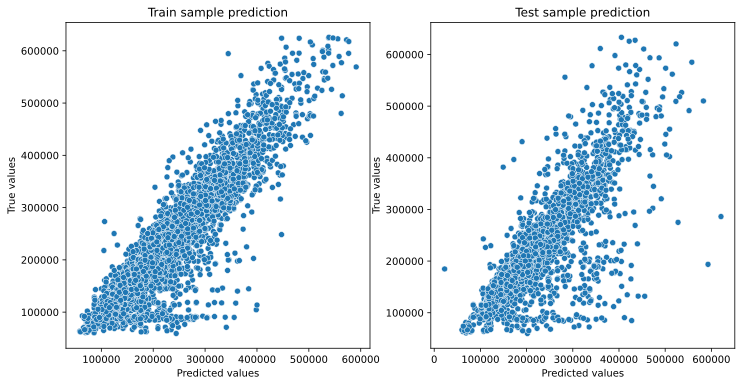

In [80]:
y_train_preds = rf_model.predict(X_train)
y_test_preds = rf_model.predict(X_valid)

evaluate_preds(y_train, y_train_preds, y_valid, y_test_preds)

#### Кросс-валидация ####

In [81]:
cv_score = cross_val_score(rf_model, X_train, y_train, scoring='r2', cv=KFold(n_splits=3, \
                                                                              shuffle=True, random_state=21))
cv_score

array([0.71264221, 0.73310277, 0.73641871])

In [82]:
cv_score.mean()

0.7273878939349586

#### Определение важности признаков ####

In [83]:
feature_importances = pd.DataFrame(zip(X_train.columns, rf_model.feature_importances_), 
                                   columns=['feature_name', 'importance'])

feature_importances.sort_values(by='importance', ascending=False)

,feature_name,importance
1,Square,0.405967
6,Social_1,0.118862
8,Social_3,0.092907
7,Social_2,0.067244
5,Ecology_1,0.045858
3,KitchenSquare,0.032548
14,MedSquareByRooms,0.031221
13,MedSquareByRoomsDistrictId,0.031038
2,LifeSquare,0.030690
10,Healthcare_1,0.026401


## Прогнозирование на тестовом датасете ##

In [84]:
test_df.shape

(5000, 28)

In [85]:
submit = pd.read_csv('./data/sample_submission.csv')
submit.head()

,Id,Price
0,725,200000.0
1,15856,200000.0
2,5480,200000.0
3,15664,200000.0
4,14275,200000.0


In [86]:
predictions = rf_model.predict(test_df)
predictions

array([164107.9987424 , 194254.17524744, 369685.39686674, ...,
       317218.72842071, 211436.13733056, 186249.07486793])

In [87]:
submit['Price'] = predictions
submit.head()

,Id,Price
0,725,164107.998742
1,15856,194254.175247
2,5480,369685.396867
3,15664,353572.738376
4,14275,134757.455341


In [88]:
submit.to_csv('rf_submit.csv', index=False)